# Identity Fraud From Enron Email

### Understanding the Dataset and Question

The purpose of this project is to use machine learning tools to identify Enron 
employees (Persons of Interest -POI) who have committed fraud based on the public Enron 
financial and email dataset. Enron is an energy trading company that had the largest case 
of corporate fraud in US history. POIs are one of 3: indicted, settled without admitting guilt,
or testified in exchange of immunity.

#### The Dataset

The dataset contains about 146 users (18 of them are considered POIs, while 128 are non-POIs) mostly real emails exchanged by senior management of Enron. We can use machine learning on this dataset to answer questions like "can we identify patterns in the emails?", using regression we will be able to understand the relationship between the people's salary and their bonuses for example, and using clustering we can identify who was a member of the board of directors, and who was just an employee.

The dataset has 21 features, that are either financial, email or (POI/non-POI)-related.

In [355]:
#!/usr/bin/python
import warnings; warnings.simplefilter('ignore')
import sys
import pickle
from time import time
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

sys.path.append("C:/JBasineni/Mach_learn/ud120-projects-master/ud120-projects-master/tools/")
sys.path.append('C:/JBasineni/Mach_learn/ud120-projects-master/ud120-projects-master/choose_your_own')
sys.path.append('C:/JBasineni/Mach_learn/ud120-projects-master/ud120-projects-master/datasets_questions')
sys.path.append('C:\JBasineni/Mach_learn/ud120-projects-master')
sys.path.append("../tools/")

import os
os.chdir('C:/JBasineni/Mach_learn/ud120-projects-master/ud120-projects-master/final_project')

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

%pylab inline

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

enron_data = pickle.load(open("final_project_dataset.pkl", "rb") )
print ('Number of people in the Enron dataset: {0}'.format(len(enron_data)))




Populating the interactive namespace from numpy and matplotlib
Number of people in the Enron dataset: 146


In [356]:
nb_people=len(enron_data)
print ('Number of people in the dataset: ',nb_people)

pois = [x for x, y in enron_data.items() if y['poi']]
print ('Number of POI\'s: {0}'.format(len(pois)))
print ("Proportion of POIs in the dataset:",len(pois)/nb_people)
#nb_poi=sum([data_dict[key]['poi']==1 for key in data_dict])
#print ("Number of persons of interest (POI): ",nb_poi)
#print ("Proportion of POIs in the dataset:",nb_poi/nb_people)

Number of people in the dataset:  146
Number of POI's: 18
Proportion of POIs in the dataset: 0.1232876712328767



We observe that out of 146 persons included in the data set, only 18 persons are considered as persons of interest, which reprents 12.3%. The data set is very unbalanced.

How many features are available in the data set?

In [357]:
# No of features in the ENRON dataset
import pprint
print ('Number of features for each person in the Enron dataset: {0}'.format(len(list(enron_data.values())[0])))
print (' ')
print ('Features Available ')
#pprint.pprint(list(enron_data.values())[1] )
pprint.pprint(list(enron_data['PRENTICE JAMES'].keys()))

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'expenses', 'total_stock_value', 'bonus', 'from_poi_to_this_person', 'shared_receipt_with_poi'] # You will need to use more features

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
POI_label = ['poi']
total_features = POI_label + financial_features + email_features

Number of features for each person in the Enron dataset: 21
 
Features Available 
['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']


####   Outlier investigation
Are there outliers in the data set? We can start by creating a scatter plot with the salary and bonus features.

In [358]:
#Explore the names of the people

#pprint.pprint(list(enron_data.keys()))
pprint.pprint(enron_data['THE TRAVEL AGENCY IN THE PARK'])

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}


Clearly 'THE TRAVEL AGENCY IN THE PARK' is not a valid person and also all the values have 'NaN'. So this can be removed from out dataset. We also should remove any person who has all the values in the dataset as 'NaN'.

In [359]:
#Check for people whose total payments and total stock value is NULL
outliers =[]
for key in enron_data.keys():
    if  (enron_data[key]['total_payments']=='NaN') & (enron_data[key]['total_stock_value']=='NaN') :
        outliers.append(key)
print ("What's the name of the outlier:",(outliers))

pprint.pprint( (enron_data['POWERS WILLIAM']))

What's the name of the outlier: ['CHAN RONNIE', 'POWERS WILLIAM', 'LOCKHART EUGENE E']
{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': -17500,
 'director_fees': 17500,
 'email_address': 'ken.powers@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 26,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 0,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 12,
 'to_messages': 653,
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}


On further exploration we also found 'CHAN RONNIE', 'POWERS WILLIAM', 'LOCKHART EUGENE E' have toal payments and total stock value as NULL . They also do not have any messages to and from any POI. So I am planning to remove these from the dataset.

In [360]:
# Removing the outliers
enron_data.pop('THE TRAVEL AGENCY IN THE PARK',0)
enron_data.pop('POWERS WILLIAM',0)
enron_data.pop('LOCKHART EUGENE E',0)
enron_data.pop('CHAN RONNIE',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': -98784,
 'director_fees': 98784,
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 32460,
 'restricted_stock_deferred': -32460,
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

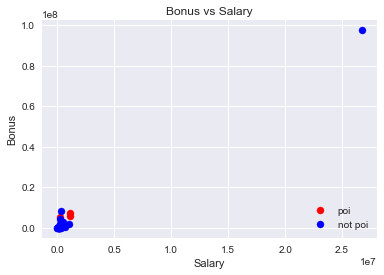

In [361]:
features_list = ["poi","salary", "bonus"]
data = featureFormat(enron_data, features_list, sort_keys = True)
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]

plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.legend(loc='lower right')
plt.title("Bonus vs Salary")
plt.show()


We can clearly see an outlier with a salary higher than 25,000,000 dollars and a bonus higher than 80,000,000 dollars but not a POI. But who is this outlier?

In [362]:
outliers =[]
for key in enron_data.keys():
    if (enron_data[key]['bonus']!='NaN')& (enron_data[key]['salary']!='NaN'):
        if (int(enron_data[key]['bonus'])>0.8*1e8) & (int(enron_data[key]['salary'])>2.5*1e7):
            outliers.append(key)
print ("What's the name of the outlier:",outliers)

What's the name of the outlier: ['TOTAL']


That solves the mystery. It appears that there is a bug in the data set. The outlier is in fact the total of each variable. Let's remove this outlier.

In [363]:
# We use the method pop to remove in the dictionary the item 'TOTAL.
enron_data.pop('TOTAL',0)
data = featureFormat(enron_data, features_list)

LEts try to check for Outliers again after removing the total row from dataset

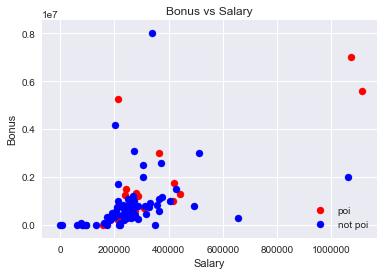

In [364]:
# Let's check for Outliers again
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]

plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.legend(loc='lower right')
plt.title("Bonus vs Salary")
plt.show()

Now that we have cleaned up our dataset for Outliers and data elements which do not make sense  we can move to feature selection 

# Feature Selection/Engineering

### New Feature

Persons of interest may have strong email connections. POIs might send emails to other POIs at a higher rate than the rest of the population. For this reason, let's create two new features: one that represents the fraction of emails that a person sent to POIs, and another feature that represents the fraction of emails that a person received from POIs.

In [365]:
# Functions to calculate the fraction of emails from /to a person and a POI
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction


for name in enron_data:

    data_point = enron_data[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi
features_list_n = total_features
features_list_n.remove('email_address')
features_list_n =  features_list_n + ['fraction_from_poi', 'fraction_to_poi']
pprint.pprint (features_list_n)

['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'fraction_from_poi',
 'fraction_to_poi']


In [366]:
fraction_to_poifraction =[enron_data[key]["fraction_to_poi"] for key in enron_data]
fraction_from_poi=[enron_data[key]["fraction_from_poi"] for key in enron_data]
poi=[enron_data[key]["poi"]==1 for key in enron_data]

In [367]:

def takeSecond(elem):
    """ take second element for sort
    """
    return elem[1]

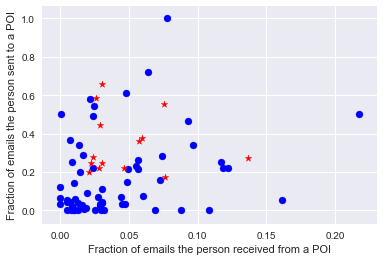

In [368]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in enron_data:
        if enron_data[i][key]=="NaN" or enron_data[i][normalizer]=="NaN":
            new_list.append(0.)
        elif enron_data[i][key]>=0:
            new_list.append(float(enron_data[i][key])/float(enron_data[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in enron_data:
    enron_data[i]["fraction_from_poi"]=fraction_from_poi[count]
    enron_data[i]["fraction_to_poi"]=fraction_to_poi[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi", "fraction_to_poi"]    
    ### store to my_dataset for easy export below
my_dataset = enron_data


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    #plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*",label='poi')
    else:
        plt.scatter(from_poi, to_poi, color="b", label='not poi')

plt.xlabel('Fraction of emails the person received from a POI') 
plt.ylabel('Fraction of emails the person sent to a POI')  
plt.show()

We can observe that these two features have a discriminating power between POI and non POI. For example, we can observe that there are no POIs with fraction_to_poi<0.2.



To select the features we will use an automated feature selection function named SelectKBest from the sklearn library. We will tune the parameter K (number of features) at the same time we tune the parameters of the machine learning algorithm during the implementation of cross-validation. If we select the number of features on the entire data set and then we tune the parameters of the machine learning algorithm there is a risk of overfitting.

In [369]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_n, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [371]:
import pprint
pprint.pprint(features_list_n)


['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'fraction_from_poi',
 'fraction_to_poi']


In [372]:
# intelligently select features (univariate feature selection)
import pprint
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k = 10)
selector.fit(features, labels)
scores = zip(features_list_n[1:], selector.scores_)
sorted_scores = sorted(scores, key = takeSecond, reverse = True)
pprint.pprint('SelectKBest scores: ')
pprint.pprint( sorted_scores)
all_features =  POI_label + [(i[0]) for i in sorted_scores[0:20]]
pprint.pprint( all_features)
kBest_features = POI_label + [(i[0]) for i in sorted_scores[0:10]]
pprint.pprint( 'KBest')
pprint.pprint( kBest_features)

#print(my_dataset)
for emp in enron_data:
    for f in enron_data[emp]:
        if enron_data[emp][f] == 'NaN':
            # fill NaN values
            enron_data[emp][f] = 0

my_dataset = enron_data

'SelectKBest scores: '
[('exercised_stock_options', 24.25047235452619),
 ('total_stock_value', 23.613740454440887),
 ('bonus', 20.25718499812395),
 ('salary', 17.71787357924329),
 ('fraction_to_poi', 15.946248696687636),
 ('deferred_income', 11.222175285805182),
 ('long_term_incentive', 9.62221216430468),
 ('restricted_stock', 8.947938884292649),
 ('total_payments', 8.570823078730976),
 ('shared_receipt_with_poi', 8.277457991443601),
 ('loan_advances', 7.066710861319749),
 ('expenses', 5.815328001904854),
 ('from_poi_to_this_person', 5.041257378669385),
 ('other', 4.070343006434408),
 ('fraction_from_poi', 2.963990314926164),
 ('from_this_person_to_poi', 2.295183195738003),
 ('director_fees', 1.9332910310121643),
 ('to_messages', 1.5634425546665922),
 ('deferral_payments', 0.24033464535223048),
 ('from_messages', 0.18071817710224855),
 ('restricted_stock_deferred', 0.06696644496108223)]
['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'fraction_to_poi',
 

In [313]:


# dataset without new features
from sklearn import preprocessing
data = featureFormat(my_dataset, kBest_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

# dataset with new features
kBest_new_features = kBest_features + ['fraction_from_poi', 'fraction_to_poi']
data = featureFormat(my_dataset, kBest_new_features, sort_keys = True)
new_labels, new_features = targetFeatureSplit(data)
new_features = scaler.fit_transform(new_features)

In [314]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def tune_params(grid_search, features, labels, params, iters = 80):
    """ given a grid_search and parameters list (if exist) for a specific model,
    along with features and labels list,
    it tunes the algorithm using grid search and prints out the average evaluation metrics
    results (accuracy, percision, recall) after performing the tuning for iter times,
    and the best hyperparameters for the model
    """
    acc = []
    pre = []
    recall = []
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)

        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    print ("accuracy: {}".format(np.mean(acc)))
    print ("precision: {}".format(np.mean(pre)))
    print ("recall: {}".format(np.mean(recall)))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))

In [315]:
from sklearn.model_selection import GridSearchCV

# 1. Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_param = {}
nb_grid_search = GridSearchCV(estimator = nb_clf, param_grid = nb_param)
print("Naive Bayes model evaluation")
tune_params(nb_grid_search, features, labels, nb_param)
print("Naive Bayes model evaluation with new features")
tune_params(nb_grid_search, new_features, new_labels, nb_param)

Naive Bayes model evaluation
accuracy: 0.8470930232558139
precision: 0.3991815476190476
recall: 0.33036706349206346
Naive Bayes model evaluation with new features
accuracy: 0.8325581395348836
precision: 0.35005005411255413
recall: 0.31953373015873016


In [252]:
# 2. Support Vector Machines
from sklearn import svm
svm_clf = svm.SVC()
svm_param = {'kernel':('linear', 'rbf', 'sigmoid'),
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 1, 10, 100, 1000]}
svm_grid_search = GridSearchCV(estimator = svm_clf, param_grid = svm_param)

print("SVM model evaluation")
tune_params(svm_grid_search, features, labels, svm_param)
print("SVM model evaluation with New Features")
tune_params(svm_grid_search, new_features, new_labels, svm_param)

SVM model evaluation
accuracy: 0.8645348837209301
precision: 0.15124999999999997
recall: 0.06362103174603176
kernel = 'sigmoid', 
gamma = 1, 
C = 100, 
SVM model evaluation with New Features
accuracy: 0.8630813953488371
precision: 0.13458333333333333
recall: 0.06457837301587302
kernel = 'linear', 
gamma = 1, 
C = 10, 


In [316]:
# 3. Decision Tree
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_param = {'criterion':('gini', 'entropy'),
'splitter':('best','random')}
dt_grid_search = GridSearchCV(estimator = dt_clf, param_grid = dt_param)

print("Decision Tree model evaluation")
tune_params(dt_grid_search, features, labels, dt_param)
print("Decision Tree model evaluation with New Features")
tune_params(dt_grid_search, new_features, new_labels, dt_param)

Decision Tree model evaluation
accuracy: 0.8159883720930232
precision: 0.306113122988123
recall: 0.3072470238095238
criterion = 'gini', 
splitter = 'best', 
Decision Tree model evaluation with New Features
accuracy: 0.8220930232558139
precision: 0.3005963827838828
recall: 0.33601686507936507
criterion = 'entropy', 
splitter = 'random', 


In [317]:
# 4. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10)
rf_param = {}
rf_grid_search = GridSearchCV(estimator = rf_clf, param_grid = rf_param)

print("Random Forest model evaluation")
tune_params(rf_grid_search, features, labels, rf_param)
print("Random Forest model evaluation with New Features")
tune_params(rf_grid_search, new_features, new_labels, rf_param)

Random Forest model evaluation
accuracy: 0.8659883720930232
precision: 0.399375
recall: 0.16754464285714285
Random Forest model evaluation with New Features
accuracy: 0.8715116279069767
precision: 0.43125
recall: 0.1721875


In [318]:
# 5. Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_param = {'tol': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 0.01, 0.001, 0.0001]}
lr_grid_search = GridSearchCV(estimator = lr_clf, param_grid = lr_param)

print("Logistic Regression model evaluation")
tune_params(lr_grid_search, features, labels, lr_param)
print("Logistic Regression model evaluation with new features")
tune_params(lr_grid_search, new_features, new_labels, lr_param)

Logistic Regression model evaluation
accuracy: 0.8723837209302324
precision: 0.0
recall: 0.0
tol = 1, 
C = 0.1, 
Logistic Regression model evaluation with new features
accuracy: 0.8723837209302324
precision: 0.0
recall: 0.0
tol = 1, 
C = 0.1, 


In [373]:


# dataset without new features
from sklearn import preprocessing
data = featureFormat(my_dataset, all_features, sort_keys = True)
labels1, features1 = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features1 = scaler.fit_transform(features1)



In [374]:
from sklearn.feature_selection import SelectKBest, f_classif
def feature_selection(nb_features,features, labels):
    selector = SelectKBest(f_classif, k=nb_features)
    selector.fit(features, labels)
    return selector

In [375]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif

def test_classifier(clf, labels, features,nb_features, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    precision=0
    recall=0
    f1=0
    f2=0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
            
        #Selection of the best K features   
       # selector=feature_selection(nb_features,features_train, labels_train)
        selector=feature_selection(nb_features,features_train, labels_train)
        features_train_transformed = selector.transform(features_train)
        features_test_transformed  = selector.transform(features_test)   
            
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train_transformed, labels_train)
        predictions = clf.predict(features_test_transformed)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                break
   
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
    except:
        #print "Got a divide by zero when trying out:", clf
        None
    return precision,recall,f1,f2

In [376]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
nb_features_orig=len(features1[1])
print(nb_features_orig)
#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]

#Classifier
clf=GaussianNB()

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,20):
    
    #We use cross-validation and we calculate precision and recall metrics
    precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
    #We record the evaluation metrics for each case               
    precision_result.append(precision)
    recall_result.append(recall)     
    f1_result.append(f1)
    f2_result.append(f2)
    nb_feature_store.append(nb_features)

20


In [327]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
nb_features_orig=len(features[1])
nb_features_orig1=len(all_features[1])
print(nb_features_orig1)
#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]

#Classifier
clf=GaussianNB()

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    
    #We use cross-validation and we calculate precision and recall metrics
    precision,recall,f1,f2=test_classifier(clf, labels, features,nb_features, folds = 1000)
    #We record the evaluation metrics for each case               
    precision_result.append(precision)
    recall_result.append(recall)     
    f1_result.append(f1)
    f2_result.append(f2)
    nb_feature_store.append(nb_features)
    
    
    
   

23


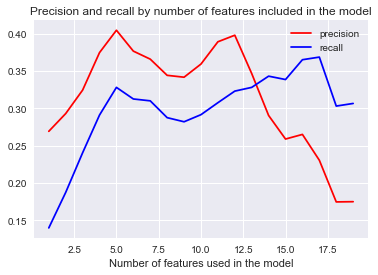

In [377]:
plt.plot(range(1,nb_features_orig),precision_result,c='red',label='precision')
plt.plot(range(1,nb_features_orig),recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

We observe that if we select 5 best features we have the best performance with a precision and recall higher than 0.3. 
What are the exact precision and recall when we select the 5 best features?

In [378]:
print ("Precsion when the 5 best features are selected:",precision_result[4])
print ("Recall when the 5 best features are selected",recall_result[4])

Precsion when the 5 best features are selected: 0.40443896424167697
Recall when the 5 best features are selected 0.328


In [380]:
import pprint
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k = 10)
selector.fit(features1, labels1)
scores = zip(features_list_n[1:], selector.scores_)
sorted_scores = sorted(scores, key = takeSecond, reverse = True)
pprint.pprint('SelectKBest scores: ')
pprint.pprint( sorted_scores)

'SelectKBest scores: '
[('salary', 24.25047235452619),
 ('deferral_payments', 23.613740454440904),
 ('total_payments', 20.257184998123947),
 ('loan_advances', 17.717873579243303),
 ('bonus', 15.946248696687636),
 ('restricted_stock_deferred', 11.222175285805275),
 ('deferred_income', 9.622212164304681),
 ('total_stock_value', 8.94793888429267),
 ('expenses', 8.570823078730982),
 ('exercised_stock_options', 8.277457991443592),
 ('other', 7.06671086131975),
 ('long_term_incentive', 5.815328001904875),
 ('restricted_stock', 5.041257378669378),
 ('director_fees', 4.07034300643441),
 ('to_messages', 2.963990314926179),
 ('from_poi_to_this_person', 2.295183195738),
 ('from_messages', 1.9332910310121656),
 ('from_this_person_to_poi', 1.5634425546665953),
 ('shared_receipt_with_poi', 0.2403346453522309),
 ('fraction_from_poi', 0.18071817710224897)]


In [381]:
import pandas as pd
feature_importance=pd.DataFrame([features1[1:],list(selector.scores_)]).T
feature_importance.columns=['feature_name','score']
feature_importance.sort_values('score',ascending=False)

,feature_name,score
0,"[[0.007505942637650726, 0.006142103383251037, ...","[24.25047235452619, 23.613740454440904, 20.257..."


### b. K-Nearest Neighbors
Let's try the K-Nearest Neighbors algorithm. Before training this algorithm, it's important to rescale the features because the algorithm compute the euclidian distance and it will be more affected my large features.

In [385]:

from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler()
features=min_max_scaler.fit_transform(features1)

One parameter which is important to tune for the k-Nearest-neighbors is the number of neighbors. If we set n_neighbors=1, the person is going to be labeled based on the closest neighbor. If we set n_neighbors=10, the person is going to labeled based on the 10 nearest neighbors. When the number of neighbors is small, the bias is low, however the variance is high. That's why it's important to find the right trade-off by using a cross-validation method to tune the parameter.

In [386]:
from sklearn.neighbors import KNeighborsClassifier

nb_features_orig=len(features1[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]

nb_neighbors_store=[]
nb_feature_store=[]

#Number of neighbours tested
nb_neighbors=[1,2,3,5,10,20,30]

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    #Number of neighbours
    for k in range(len(nb_neighbors)):
        
        #classifier
        clf =KNeighborsClassifier(n_neighbors=nb_neighbors[k])
        #We use cross-validation and we calculate precision and recall metrics
        precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
        
        #We record the evaluation metrics for each case
        precision_result.append(precision)
        recall_result.append(recall)     
        f1_result.append(f1)
        f2_result.append(f2)
        nb_feature_store.append(nb_features)
        nb_neighbors_store.append(nb_neighbors[k])

In [387]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,nb_neighbors_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','nb_neighbors','precision','recall','f1','f2']
result.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1.0,1.0,0.188815,0.1840,0.186376,0.184943
1,1.0,2.0,0.267631,0.0740,0.115942,0.086519
2,1.0,3.0,0.212963,0.1035,0.139300,0.115359
3,1.0,5.0,0.364769,0.1025,0.160031,0.119715
4,1.0,10.0,0.000000,0.0000,0.000000,0.000000


First, we want to determine how many features we want to select to have the best precision and recall.

We select the best F2-score for each number of features included in the model. We use the F2 score instead of F1 socre because it puts more weight on recall. This is important because recall tends to be lower, and we want to find precision and recall higher than 0.3.

In [388]:
result_sort_by_f2=result.sort_values('f2',ascending=False)
result_group=result_sort_by_f2.groupby('nb_feature')

In [390]:

top_param_by_nbfeature=result_group.head(1).sort_values('nb_feature')
top_param_by_nbfeature.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1.0,1.0,0.188815,0.1840,0.186376,0.184943
9,2.0,3.0,0.376596,0.1770,0.240816,0.197987
14,3.0,1.0,0.293750,0.2820,0.287755,0.284274
21,4.0,1.0,0.295512,0.2930,0.294251,0.293499
28,5.0,1.0,0.207324,0.1925,0.199637,0.195293


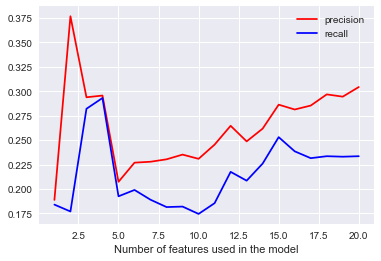

In [391]:
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.precision,c='red',label='precision')
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.recall,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.legend()
plt.show()

In [392]:

top_param_by_nbfeaturetop_para [top_param_by_nbfeature.nb_feature==4]

,nb_feature,nb_neighbors,precision,recall,f1,f2
21,4.0,1.0,0.295512,0.293,0.294251,0.293499


In [402]:
from sklearn import tree

nb_features_orig=len(features1[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]


#Param
dt_param = {'criterion':('gini', 'entropy'),
'splitter':('best','random')}

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    #Number of neighbours
           
        #classifier
        clf = tree.DecisionTreeClassifier()
        #We use cross-validation and we calculate precision and recall metrics
        precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
        
        #We record the evaluation metrics for each case
        precision_result.append(precision)
        recall_result.append(recall)     
        f1_result.append(f1)
        f2_result.append(f2)
        nb_feature_store.append(nb_features)




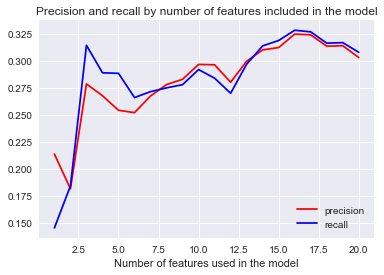

In [405]:
plt.plot(nb_feature_store,precision_result,c='red',label='precision')
plt.plot(nb_feature_store,recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

In [407]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','precision','recall','f1','f2']
result.head(20)

,nb_feature,precision,recall,f1,f2
0,1.0,0.213549,0.1450,0.172722,0.154948
1,2.0,0.181281,0.1840,0.182630,0.183450
2,3.0,0.278689,0.3145,0.295513,0.306620
3,4.0,0.267717,0.2890,0.277951,0.284477
4,5.0,0.254185,0.2885,0.270258,0.280915
5,6.0,0.252013,0.2660,0.258818,0.263080
6,7.0,0.267488,0.2715,0.269479,0.270688
7,8.0,0.278059,0.2750,0.276521,0.275606
8,9.0,0.282952,0.2780,0.280454,0.278976
9,10.0,0.296748,0.2920,0.294355,0.292937
